<a href="https://colab.research.google.com/github/succSeeded/ts-2025/blob/main/hw1-2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TS Labs Forecasting

In this laboratory work, you will encounter a real chaotic series and try to forecast it!

## General Rules

- You can work in small groups: 1-2 people

- Deadline: 07.12.24 23:59

- To estimate performance of the algorithm you should report the following metrics:

    - MAE, MSE, MAPE for $1, 5, 10, 20, 30, 50$ steps ahead predictions

    - $\%$ of non-predictable points for $1, 5, 10, 20, 30, 50$ steps ahead predictions

- You should submit a Jupyter notebook with brief descriptions of what happens in each cell.

# Lab 1 - ARIMA+NN

1. (2 points) Apply ARIMA model for forecasting. Explain the choice of p,d,q paramters. Did you
notice anything strange?
2. (3 points) Implement LSTM architectures for the given dataset. Estimate its performance.
3. (3 points) Implement TCN architectures for the given dataset. Estimate its performance.
4. (2 points) Compare results of the algorithms.

## Load in the dataset

In [4]:
%load_ext jupyter_black

In [5]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from tqdm import trange

In [6]:
train = np.load(join("data", "train.npy"))
test = np.load(join("data", "test.npy"))

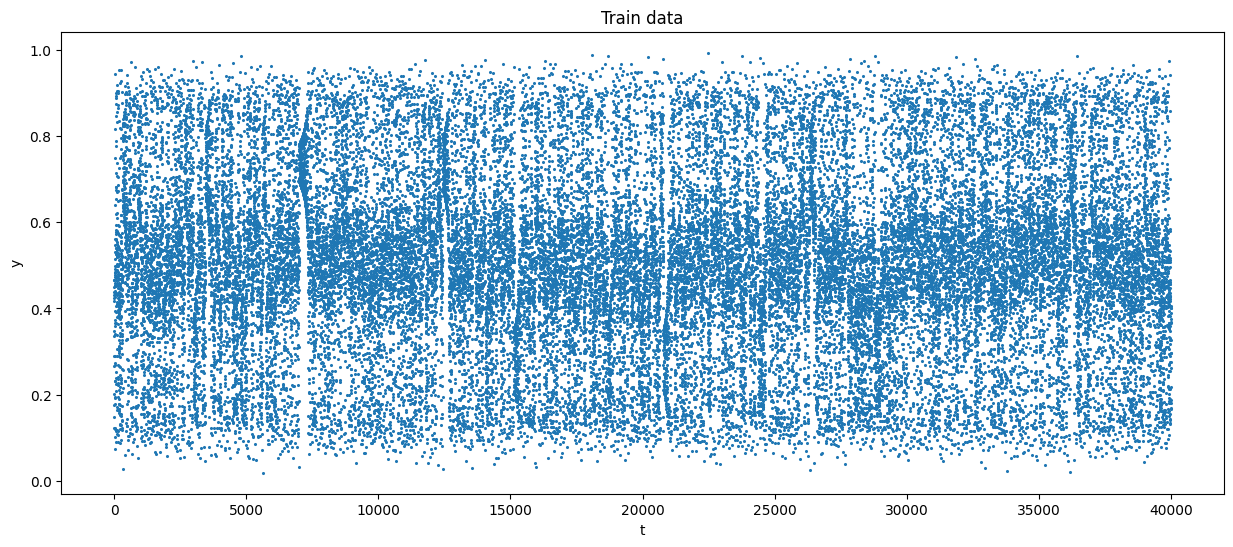

In [7]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(40_000), train, s=1.5)
plt.title("Train data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

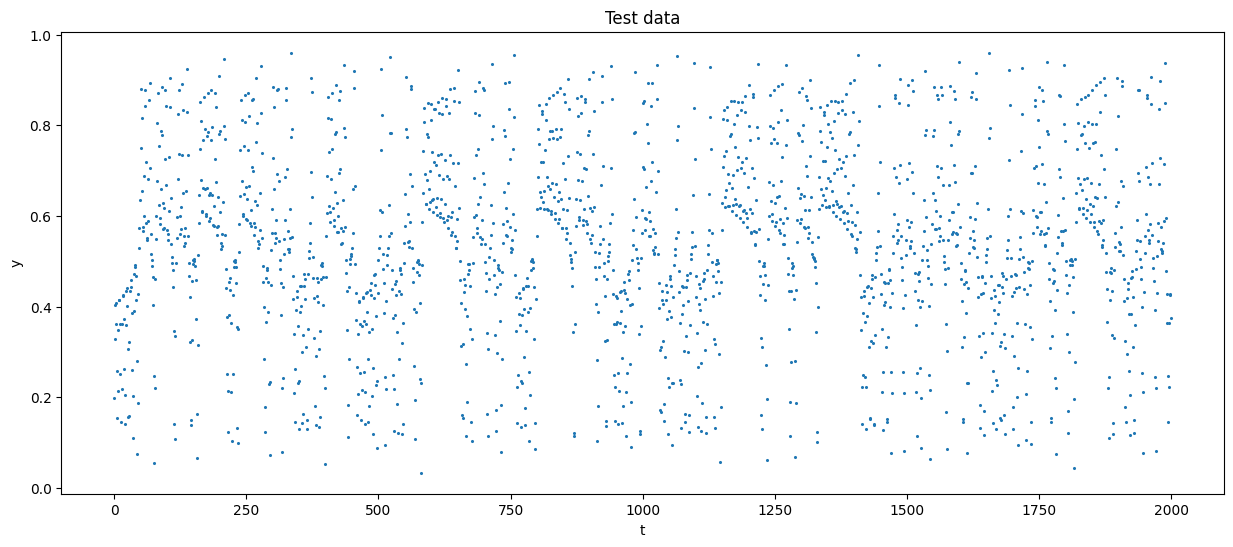

In [8]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(2_000), test, s=1.5)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

## Exploring the dataset

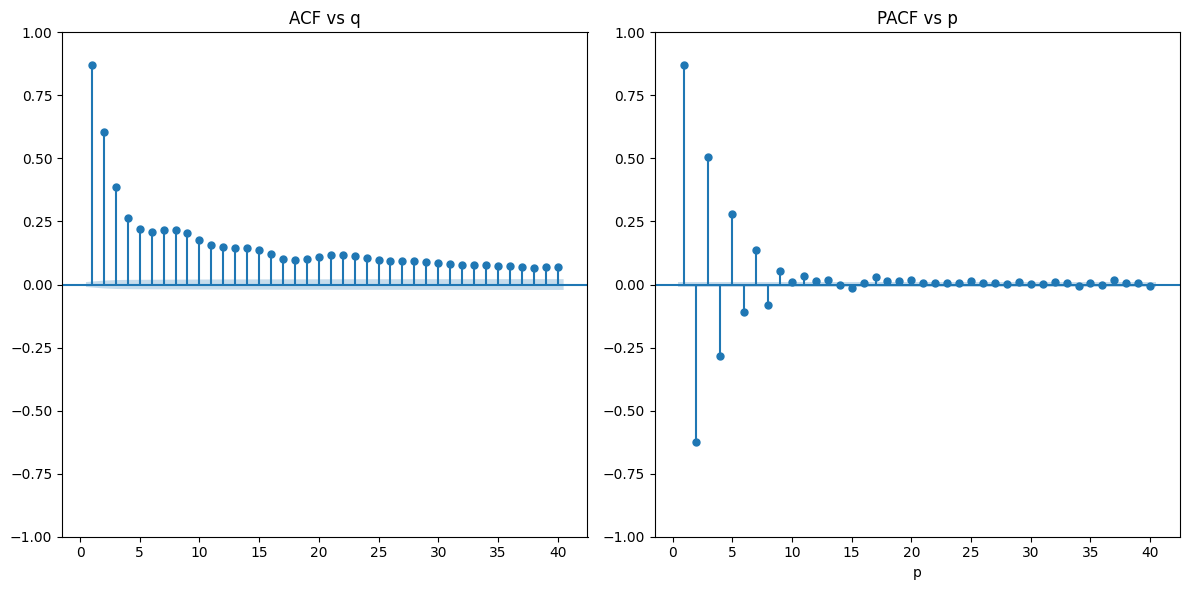

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

k = 40

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(
    train,
    lags=k,
    alpha=0.05,
    title="ACF vs q",
    zero=False,
    ax=axes[0],
    # color="blue",
    # vlines_kwargs={"colors": "blue"},
)
plot_pacf(
    train,
    lags=k,
    alpha=0.05,
    title="PACF vs p",
    zero=False,
    ax=axes[1],
    # color="blue",
    # vlines_kwargs={"colors": "blue"},
)
plt.xlabel("p")
plt.tight_layout()
plt.show()

The ACF plot suggests that $q$ should be set to 3 and the PACF plot suggests that $p$ should be set to 4, since they experience almost no variation after said values

Let us figure out whether the TS is stationary using unit root:

In [25]:
from statsmodels.tsa.stattools import adfuller

stat, pvalue, usedlag, nobs, crit, icbest = adfuller(train, store=False)
print(f"Augmented Dickey–Fuller stat value: {stat:.4f}")
print(f"p-value: {pvalue:.4f}")
print(f"Critical values: {crit}")

Augmented Dickey–Fuller stat value: -24.1018
p-value: 0.0000
Critical values: {'1%': -3.430513644373252, '5%': -2.86161232705185, '10%': -2.5668084973673153}


This implies that the series is likely to be stationary and $d$ nees to be set to 0.

## ARIMA

Now, let us implement ARMA and ARIMA estimators:

In [27]:
def get_batched_data(data, batch_size):
    split_idx = [i * batch_size for i in range(batch_size, data.shape[0] // batch_size)]
    if data.shape[0] % batch_size:
        split_idx = split_idx[:-1]
    return np.split(data, split_idx)

In [28]:
from numpy.lib.stride_tricks import sliding_window_view


class AR(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        p: int,
        lr: float = 1e-1,
        max_iter: int = 100,
        tol: float = 1e-4,
        batch_size: int = 64,
        bias: bool = True,
    ):
        self.weights_ = np.random.normal(size=(p,))
        self.bias_ = np.random.normal()
        self.order = (p,)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        if self.batch_size_ < self.order[0]:
            raise ValueError(f"Batch size {batch_size} smaller than order {p}")

    def fit(self, X):
        p = self.order[0]
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        min_loss_id = 0
        min_weights = self.weights_
        min_loss = np.inf
        X_batched = get_batched_data(X, self.batch_size_)
        for i in range(self.max_iter_):
            for x_batch in X_batched:
                resid = (
                    x_batch[p:]
                    - sliding_window_view(x_batch[:-1], p) @ self.weights_
                    - self.bias_
                )
                self.bias_ += self.lr_ * resid.mean()
                self.weights_ += (
                    self.lr_
                    * (resid @ sliding_window_view(x_batch[:-1], p))
                    / resid.shape[0]
                )
                loss = (resid**2).mean()
                self.loss_hist_.append(loss)
                if i != 0:
                    if loss < self.tol_:
                        self.convergence_message = "Successfully converged. "
                        break
                if loss < min_loss:
                    min_loss = loss
                    min_weights = self.weights_
                    min_loss_id = len(self.loss_hist_) - 1
                if len(self.loss_hist_) - min_loss_id > 10_000:
                    self.weights_ = min_weights
                    self.convergence_message = (
                        "Successfully converged (no loss improvements). "
                    )
                    break
        self.data = X[-p:]
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def forecast(self, n_steps):
        p = self.order[0]
        if len(self.data) - p < n_steps:
            new_pred_count = n_steps - (len(self.data) - p)
            # initialize new predictions as zeros and concatenate any previous ones
            if new_pred_count == n_steps:
                ans = np.zeros(new_pred_count)
            else:
                ans = np.concatenate((self.data[p:], np.zeros(new_pred_count)))
            for i in range(new_pred_count):
                ans[i] = self.data[-p:] @ self.weights_ + self.bias_
                self.data = np.concatenate((self.data, [ans[i]]))
        else:
            ans = self.data[p : p + n_steps]

        return ans

In [29]:
class ARMA(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        p: int,
        q: int,
        lr: float = 1e-1,
        max_iter: int = 100,
        tol: float = 1e-4,
        batch_size: int = 64,
    ):
        self.residual_weights_ = np.random.normal(size=(q,))
        self.residual_bias_ = np.random.normal()
        self.order = (p, q)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        self.ar_model_ = AR(p, lr=lr, max_iter=max_iter, tol=tol, batch_size=batch_size)
        if self.batch_size_ < max(self.order):
            raise ValueError(
                f"Batch size {batch_size} too small for order {self.order}"
            )

    def fit(self, X):
        p, q = self.order
        self.ar_model_ = self.ar_model_.fit(X)
        resid_ar = (
            X[p:]
            - sliding_window_view(X[:-1], p) @ self.ar_model_.weights_
            - self.ar_model_.bias_
        )
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        min_loss_id = 0
        min_weights = self.residual_weights_
        min_loss = np.inf

        for i in range(self.max_iter_):
            for bid, res_batch in enumerate(
                get_batched_data(resid_ar, self.batch_size_)
            ):
                resid_arma = (
                    res_batch[q:]
                    - sliding_window_view(res_batch[:-1], q) @ self.residual_weights_
                    - self.residual_bias_
                )
                self.residual_weights_ += (
                    self.lr_
                    * (resid_arma @ sliding_window_view(res_batch[:-1], q))
                    / resid_arma.shape[0]
                )
                self.residual_bias_ += self.lr_ * resid_arma.mean()
                loss = (resid_arma**2).mean()
                self.loss_hist_.append(loss)
                if i != 0:
                    if loss < self.tol_:
                        self.convergence_message = "Successfully converged. "
                        break
                if loss < min_loss:
                    min_loss = loss
                    min_weights = self.residual_weights_
                    min_loss_id = len(self.loss_hist_) - 1
                if len(self.loss_hist_) - min_loss_id > 1_000:
                    self.residual_weights_ = min_weights
                    self.convergence_message = (
                        "Successfully converged (no loss improvements). "
                    )
                    break
            else:
                continue
            break
        self.residuals = resid_ar[-q:]
        self.data = X[-p:]
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def forecast(self, n_steps):
        p, q = self.order
        ans = self.ar_model_.forecast(n_steps)
        if len(self.residuals) - q < n_steps:
            for i in range(len(ans)):
                res = self.residuals[-q:] @ self.residual_weights_ + self.residual_bias_
                ans[i] += res
                self.residuals = np.concatenate((self.residuals, [res]))
        else:
            ans += self.residuals[q : q + n_steps]
        return ans

In [30]:
class ARIMA(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        p: int,
        q: int,
        d: int,
        lr: float = 3e-1,
        max_iter: int = 100,
        tol: float = 1e-4,
        batch_size: int = 128,
    ):
        super().__init__()
        self.arma_model_ = ARMA(
            p, q, lr=lr, max_iter=max_iter, tol=tol, batch_size=batch_size
        )
        self.order = (p, q, d)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol

    def get_inverse_diffs(self, y_base, diff_pred, d):
        if d == 0:
            return diff_pred
        if len(y_base) < d:
            raise ValueError(
                f"Base data of incorrect shape: got {y_base.shape} instead of >={d}"
            )
        if not isinstance(y_base, np.ndarray):
            y_base = np.array([y_base])
        if len(y_base) > d:
            y_base = y_base[-d:]
        ans = np.concatenate((y_base, diff_pred)).cumsum()
        for _ in range(1, d):
            ans = ans.cumsum()
        return ans[d:]

    def fit(self, X):
        p, q, d = self.order

        X_diffs = np.diff(X, n=d)

        self.data = X[-d:]
        self.arma_model_ = self.arma_model_.fit(X_diffs)
        self.loss_hist_ = self.arma_model_.loss_hist_
        self.convergence_message = self.arma_model_.convergence_message
        return self

    def forecast(self, n_steps):
        p, q, d = self.order
        diff_pred = self.arma_model_.forecast(n_steps)
        return self.get_inverse_diffs(self.data, diff_pred, d)

In [31]:
def plot_test(model, train, test, k: int, order: tuple):

    if len(order) == 1:
        window_size = order[0]
    elif len(order) == 2:
        p, q = order
        window_size = max(p, q)
    elif len(order) == 3:
        p, q, d = order
        window_size = max(p + d, q + d)

    preds = model.forecast(k)

    plt.figure(figsize=(15, 6))
    plt.scatter(np.arange(-window_size + 1, 1), train[-window_size:], s=10)
    plt.plot(np.arange(-window_size + 1, 1), train[-window_size:])
    plt.scatter(np.arange(1, k + 1), test[:k], s=10, c="grey")
    plt.plot(np.arange(1, k + 1), test[:k], c="grey", alpha=0.7, label="true")
    plt.plot([0, 1], [train[-1], test[0]], c="grey", alpha=0.7)
    plt.scatter(np.arange(1, k + 1), preds, s=10, c="orange")
    plt.plot(np.arange(1, k + 1), preds, c="orange", alpha=0.7, label="predicted")
    plt.plot([0, 1], [train[-1], preds[0]], c="orange", alpha=0.7)
    plt.title("Test data")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()

Successfully converged (no loss improvements). Loss: 0.0031


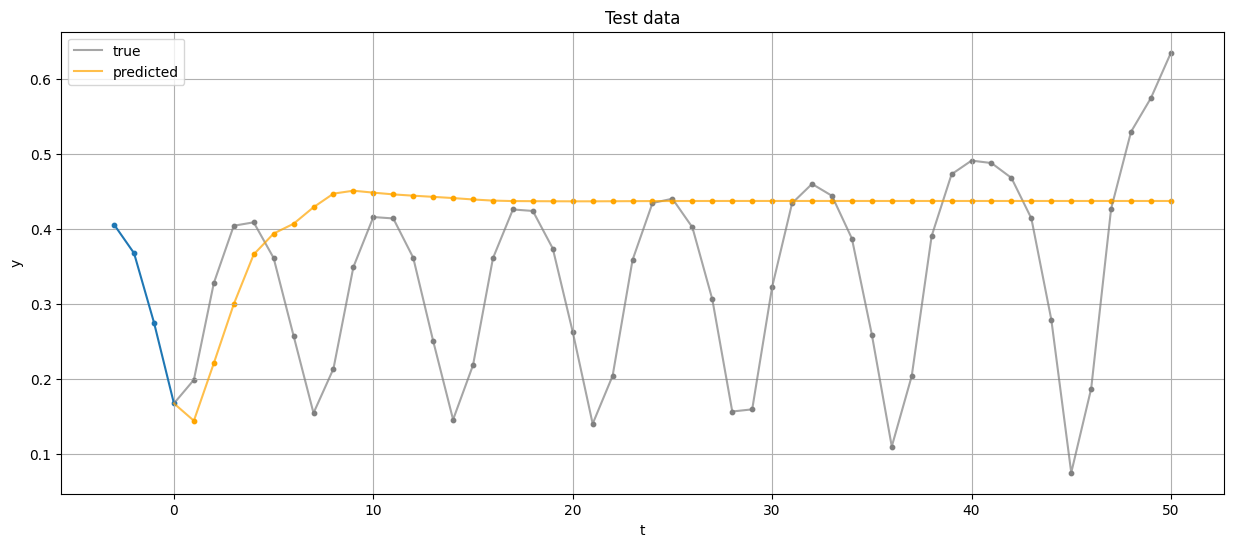

In [32]:
k = 50
p, q, d = (4, 3, 0)
order = (p, q, d)

arima = ARIMA(p, q, d).fit(train)
print(arima.convergence_message)
plot_test(arima, train, test, k, order)

In [33]:
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)


def evaluate(model, test_data):
    metrics = {
        "MAE": mean_absolute_error,
        "MSE": mean_squared_error,
        "MAPE": mean_absolute_percentage_error,
    }
    ks = [1, 5, 10, 20, 30, 50]

    results_dict = {
        metric: {
            k: metric_fn(model.forecast(k).flatten(), test_data[:k].flatten())
            for k in ks
        }
        for metric, metric_fn in metrics.items()
    }
    return pd.DataFrame.from_dict(results_dict)


arima = ARIMA(p, q, d).fit(train)
arima_results = evaluate(arima, test)
arima_results.head()
# Note that multi-step-ahead predictions here are made
# one at a time, not all in parallel

,MAE,MSE,MAPE
1,0.051988,0.002703,0.897146
5,0.093866,0.005510,0.621862
10,0.189742,0.019827,0.523535
20,0.229539,0.020937,0.407751
30,0.179544,0.024798,0.399853


n-step ahead predictions using ARIMA model converge to a mean rather quickly, but initially predict the resies rather well.

## LSTM \& TCN

Here I am going to use `torch-spaciotemporal` and `lightning` since it allows me to avoid writing boilderplate code.

Note that k-step-ahead predictions here were made in multi-step-ahead prediction paradigm since it is more natural for NNs

In [2]:
!pip install -q torch==2.8.0 torchaudio==2.8.0 torchvision==0.23.0 torch-geometric torch-sparse torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu129.html

In [9]:
%load_ext tensorboard
import torch
import torch.nn as nn
import tsl
import pytorch_lightning as pl
import torchmetrics
import functools

from pytorch_lightning.callbacks import ModelCheckpoint
from tsl.data import SpatioTemporalDataset
from tsl.data.datamodule import SpatioTemporalDataModule
from tsl.data.datamodule.splitters import TemporalSplitter
from tsl.nn.models.temporal.rnn_model import RNNModel
from tsl.nn.models.temporal.tcn_model import TCNModel
from tsl.metrics.torch import MaskedMAE, MaskedMSE, MaskedMAPE
from tsl.engines import Predictor

torch.serialization.add_safe_globals(
    [
        tsl.metrics.torch.metrics.MaskedMAE,
        tsl.metrics.torch.metrics.MaskedMSE,
        tsl.metrics.torch.metrics.MaskedMAPE,
        torch.nn.functional.mse_loss,
        torchmetrics.metric.jit_distributed_available,
        torchmetrics.utilities.data.dim_zero_sum,
        functools.partial,
        torch.nn.functional.l1_loss,
        slice,
        tsl.metrics.torch.functional.mape,
        torch.optim.Adam,
    ]
)


def train_and_evaluate(
    model_str, train, test, lookback: int = 16, batch_size: int = 64
):
    ks = [1, 5, 10, 20, 30, 50]

    results = []

    for k in ks:
        dataset = np.concatenate([train, test])

        splitter = TemporalSplitter(val_len=1_000, test_len=len(test))

        torch_dataset = SpatioTemporalDataset(
            target=dataset, horizon=k, window=lookback, stride=1
        )

        data_module = SpatioTemporalDataModule(
            dataset=torch_dataset,
            splitter=splitter,
            batch_size=batch_size,
        )
        data_module.setup()

        if model_str == "TCN":
            # TCN layer with 2 temporal convolutions and an MLP decoder
            model = TCNModel(1, 1, k)
        elif model_str == "LSTM":
            # 2-layer LSTM cell + MLP decoder w/ dropouts set to 0.1
            model = RNNModel(
                input_size=1,
                output_size=1,
                horizon=k,
                rec_layers=2,
                ff_layers=1,
                rec_dropout=0.1,
                ff_dropout=0.1,
                cell_type="lstm",
                activation="relu",
            )
        else:
            raise ValueError(
                f'Incorrect model string provided: expected "TCN" or "LSTM", got {model_str}'
            )

        print(model)

        loss_fn = MaskedMSE()

        metrics = {
            f"mae": MaskedMAE(),
            f"mse": MaskedMSE(),
            f"mape": MaskedMAPE(),
        }

        # setup predictor
        predictor = Predictor(
            model=model,  # our initialized model
            optim_class=torch.optim.Adam,  # specify optimizer to be used...
            loss_fn=loss_fn,  # which loss function to be used
            metrics=metrics,  # metrics to be logged during train/val/test
        )

        checkpoint_callback = ModelCheckpoint(
            dirpath="logs",
            save_top_k=1,
            monitor=f"val_mse",
            mode="min",
        )

        trainer = pl.Trainer(
            max_epochs=15,
            devices=1 if torch.cuda.is_available() else None,
            callbacks=[checkpoint_callback],
        )

        trainer.fit(predictor, datamodule=data_module)

        predictor.load_model(checkpoint_callback.best_model_path)
        predictor.freeze()

        results.append(trainer.test(predictor, datamodule=data_module))

    return results

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
results = train_and_evaluate("LSTM", train, test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 5080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (readout): Linear(in_features=64, out_features=1, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=1)
  )
)


/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jilezka/work/studies/ts-2025/hw1-2/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 19.1 K | train | 0    
-------------------------------------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.077     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                                                                            …

/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 19.4 K | train | 0    
-------------------------------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          2.301730819453951e-05
        test_mae           0.0035670048091560602
        test_mape          0.013417228125035763
        test_mse           2.301730819453951e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (drop

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 19.7 K | train | 0    
-------------------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         0.00035515971831046045
        test_mae            0.01016953308135271
        test_mape           0.03346521779894829
        test_mse            0.00035515968920663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (dropou

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 20.4 K | train | 0    
-------------------------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.0014566695317626
        test_mae            0.01936248689889908
        test_mape           0.07164948433637619
        test_mse           0.0014566691825166345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (dropout

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 21.0 K | train | 0    
-------------------------------------------------------------------
21.0 K    Trainable params
0         Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.00688919797539711
        test_mae           0.046753063797950745
        test_mape           0.15968160331249237
        test_mse           0.006889197509735823
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (dropout

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | RNNModel         | 22.3 K | train | 0    
-------------------------------------------------------------------
22.3 K    Trainable params
0         Non-trainable params
22.3 K    Total params
0.089     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012430233880877495
        test_mae            0.06898275762796402
        test_mape           0.22917364537715912
        test_mse           0.012430233880877495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
RNNModel(
  (input_encoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (rnn): RNN(
    (rnn): LSTM(32, 32, num_layers=2, dropout=0.1)
  )
  (readout): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=64, bias=True)
          (activation): ReLU()
          (dropout

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.025394242256879807
        test_mae            0.11058435589075089
        test_mape           0.3653079569339752
        test_mse           0.025394247844815254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
import pandas as pd

pd.DataFrame.from_dict(
    {k: results[idx][0] for idx, k in enumerate([1, 5, 10, 20, 30, 50])}
)

,1,5,10,20,30,50
test_mae,0.003567,0.010170,0.019362,0.046753,0.068983,0.110584
test_mape,0.013417,0.033465,0.071649,0.159682,0.229174,0.365308
test_mse,0.000023,0.000355,0.001457,0.006889,0.012430,0.025394
test_loss,0.000023,0.000355,0.001457,0.006889,0.012430,0.025394


## TCN

In [12]:
results = train_and_evaluate("TCN", train, test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/jilezka/work/studies/ts-2025/hw1-2/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
        (dropout): Identity()
      )
    )
  )
  (readout): Sequential(
    (0): Lambda(x: x[:, -readout_kernel_size:])
    (1): Rearrange('b t n f -> b n (f t)')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Rearrange('b n (f h) -> b h n f ', f=32, h=1)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)



  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 18.0 K | train | 0    
-------------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                                                                            …

/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jilezka/.pyenv/versions/3.11.14/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 22.3 K | train | 0    
-------------------------------------------------------------------
22.3 K    Trainable params
0         Non-trainable params
22.3 K    Total params
0.089     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         1.2555696230265312e-05
        test_mae           0.0027646240778267384
        test_mape          0.008239642716944218
        test_mse          1.2555696230265312e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
     

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 27.6 K | train | 0    
-------------------------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.110     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          9.391354251420125e-05
        test_mae           0.006913859397172928
        test_mape          0.018361087888479233
        test_mse           9.391353523824364e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
      

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 38.1 K | train | 0    
-------------------------------------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.152     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0012866536853834987
        test_mae           0.019732512533664703
        test_mape           0.06061530113220215
        test_mse           0.0012866535689681768
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
      

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 48.7 K | train | 0    
-------------------------------------------------------------------
48.7 K    Trainable params
0         Non-trainable params
48.7 K    Total params
0.195     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.004332365933805704
        test_mae           0.034124426543712616
        test_mape           0.11212334036827087
        test_mse           0.004332365933805704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
        

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train | 0    
1 | train_metrics | MetricCollection | 0      | train | 0    
2 | val_metrics   | MetricCollection | 0      | train | 0    
3 | test_metrics  | MetricCollection | 0      | train | 0    
4 | model         | TCNModel         | 69.8 K | train | 0    
-------------------------------------------------------------------
69.8 K    Trainable params
0         Non-trainable params
69.8 K    Total params
0.279     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
0         Total Flops


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.009191357530653477
        test_mae            0.05422629788517952
        test_mape           0.18318839371204376
        test_mse           0.009191357530653477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TCNModel(
  (input_encoder): Linear(in_features=1, out_features=32, bias=True)
  (convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): Norm(batch, 32)
      (1): TemporalConvNet(
        (convs): ModuleList(
          (0): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0)
          (1): TemporalConv(32, 32, kernel_size=2, stride=1, causal_padding=0, dilation=2)
        )
        

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.021995343267917633
        test_mae            0.09675677865743637
        test_mape           0.30474767088890076
        test_mse           0.021995341405272484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [13]:
pd.DataFrame.from_dict(
    {k: results[idx][0] for idx, k in enumerate([1, 5, 10, 20, 30, 50])}
)

,1,5,10,20,30,50
test_mae,0.002765,0.006914,0.019733,0.034124,0.054226,0.096757
test_mape,0.008240,0.018361,0.060615,0.112123,0.183188,0.304748
test_mse,0.000013,0.000094,0.001287,0.004332,0.009191,0.021995
test_loss,0.000013,0.000094,0.001287,0.004332,0.009191,0.021995


# Results

By far, the best results in multi-step ahead prediction are produced by the model with TCN architecture, closely followed by models with LSTM blocks and finally ARIMA. ARIMA tends to rather quickly converge to a constant value or a line on further predictions. Performance-wise, LSTM-based models are aprrox. $21\%$ faster than TCNs (170 it/s vs 140 it/s inference time).

# Lab 2 - Predictive clustering

- (5 points) Implement a predictive clustering algorithm with nonregular $z$-vectors for multistep
chaotic time series forecasting with nonpredictable points identification. If you implement one of
the possible approaches correctly, you can get at most 6 points. (one approach = one apporach for
forecasting and point classification). Estimate its performance.

- (3 points) Try several approaches for:

    - obtaining single prediction,

    - identification of nonpredictable points,

    - use of raw $z$-vectors as motives or use of cluster centroids as motives. Compare the results

- (2 points) Implement self-healing algorithm. Compare the results.

## Bonus points

- (1 bonus point) Compare the results of a predictive clustering algorithm with neural networks approaches.

- (1 bonus point) Try these algorithms on a real-life time series of your choice.

## Load in the dataset

In [2]:
%load_ext jupyter_black

In [3]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from tqdm import trange

In [4]:
train = np.load(join("data", "train.npy"))
test = np.load(join("data", "test.npy"))

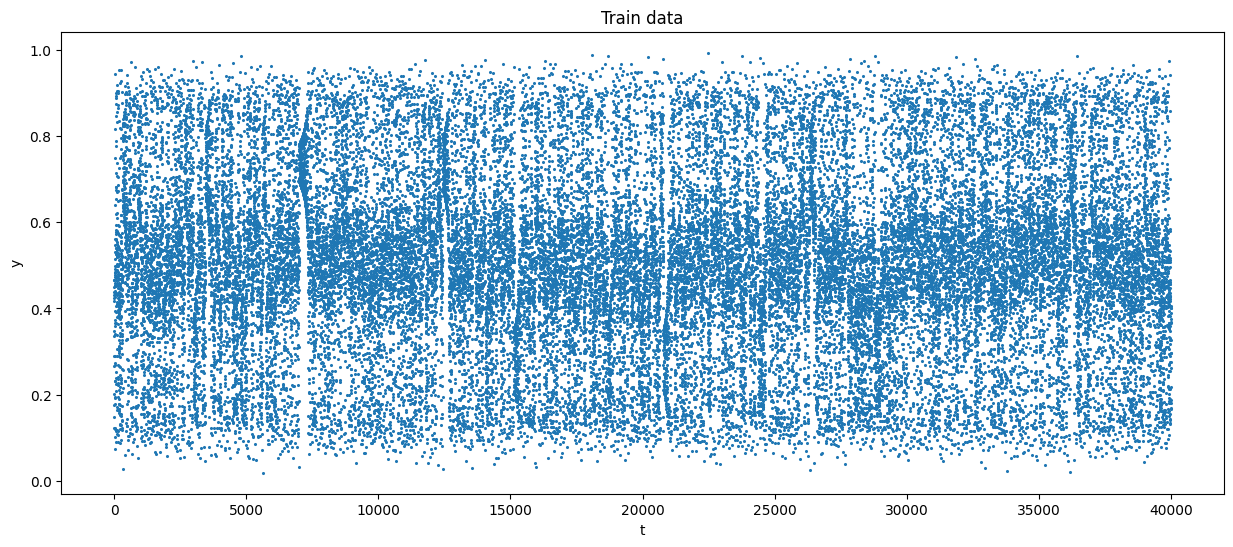

In [5]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(40_000), train, s=1.5)
plt.title("Train data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

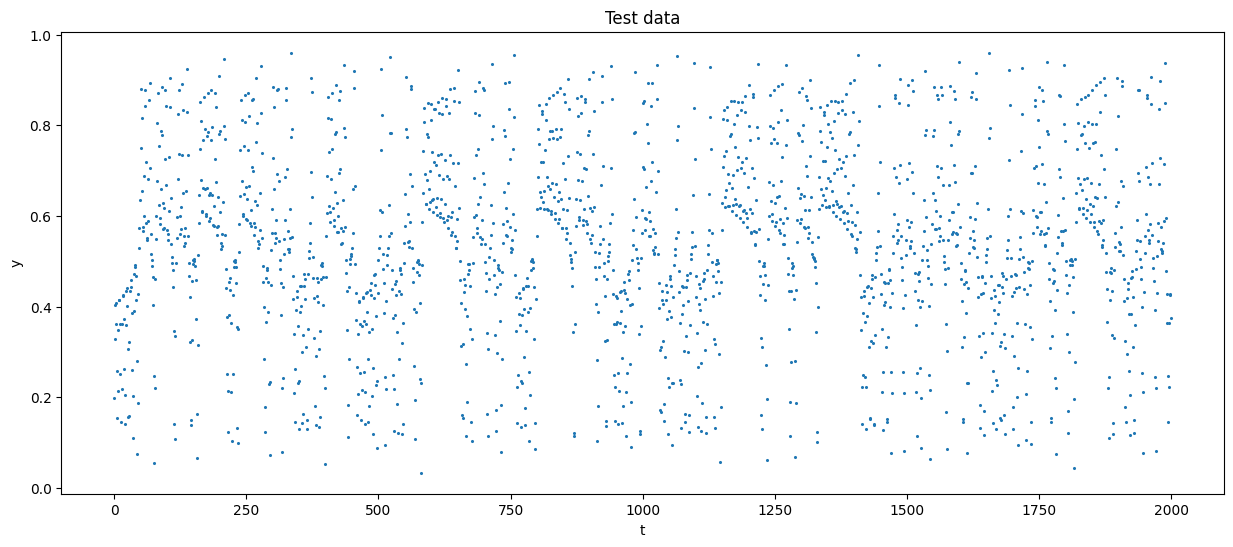

In [6]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(2_000), test, s=1.5)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

## Basic algorithm

In [7]:
import numpy as np

from tqdm import trange
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.base import BaseEstimator, RegressorMixin


class BasePredictiveClustering(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        window_size: int,
        mode: str,
        tol: float = 1e-1,
        min_prediction_pool: int = 5,
    ):
        self.window_size = window_size
        self.tol = tol
        self.min_prediction_pool = min_prediction_pool
        match mode:
            case "mean":
                self.mode = "mean"
            case "mode":
                self.mode = "mode"
            case "centroid":
                self.mode = "centroid"
                self.cluster_algo_ = DBSCAN(eps=0.01, min_samples=min_prediction_pool)
            case _:
                raise RuntimeError(
                    f'Invalid mode provided. Expected ["mean", "mode", "centroid"], got {mode}.'
                )

    def fit(self, X):
        Z_mtx = sliding_window_view(X, self.window_size)
        if self.mode != "centroid":
            self.possible_predictions_ = np.array(
                [
                    Z_mtx[i, -1]
                    for i in range(Z_mtx.shape[0] - 1)
                    if np.linalg.norm(Z_mtx[i, :-1] - Z_mtx[-1, :-1]) < self.tol
                ]
            )
        else:
            self.possible_predictions_ = np.array(
                [
                    Z_mtx[i, :]
                    for i in range(Z_mtx.shape[0] - 1)
                    if np.linalg.norm(Z_mtx[i, :-1] - Z_mtx[-1, :-1]) < self.tol
                ]
            )
        if self.possible_predictions_.shape[0] < self.min_prediction_pool:
            raise RuntimeError(
                f"Possible prediction pool too small. Try decreasing the threshold or using bigger tolerance value"
            )
        return self

    def predict(self):
        match self.mode:
            case "mean":
                pred = np.mean(self.possible_predictions_)
            case "mode":
                pred = mode(self.possible_predictions_)
            case "centroid":
                self.cluster_algo_ = self.cluster_algo_.fit(self.possible_predictions_)
                biggest_cluster = mode(
                    self.cluster_algo_.labels_[self.cluster_algo_.labels_ != -1]
                ).mode  # select the biggest cluster that is not noise
                pred = np.mean(
                    self.possible_predictions_[
                        self.cluster_algo_.labels_ == biggest_cluster
                    ],
                    axis=0,
                )[-1]
            case _:
                raise RuntimeError(
                    f'Invalid mode provided. Expected ["mean", "mode", "centroid"], got {mode}.'
                )
        return pred


pc = BasePredictiveClustering(window_size=10, mode="centroid")
pc = pc.fit(train)
print("One-step-ahead prediction:")
print(f"\tpredicted: {pc.predict():.6f}")
print(f"\ttrue: {test[0]:.6f}")

One-step-ahead prediction:
	predicted: 0.182566
	true: 0.198532


In [8]:
def get_pattern(i, K, L):
    """
    For K = 10, L = 4:
        10 -> (1, 1, 1, 10)
        19 -> (1, 1, 2, 9)
        21 -> (1, 1, 3, 1)
        91 -> (1, 1, 10, 1)
        101 -> (1, 2, 1, 1)
        1001 -> (2, 1, 1, 1)
    """
    if i + 1 > K**L or i + 1 < 1:
        raise RuntimeError(f"Index out of bounds. Expected i in [{1}, {K**L}], got {i}")

    ans = np.ones(L, dtype="int")
    for idx in range(L):
        if i == 0:
            break
        ans[L - 1 - idx] += i % K
        i = i // K
    return ans


get_pattern(10, 10, 4)

array([1, 1, 2, 1])

In [58]:
class TrajectoryPredictiveClustering(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        K: int,
        L: int,
        M: int,
        tol: float = 1e-2,
        eps1: float = 9e-2,
        eps2: float = 1e-4,
        min_prediction_pool: int = 5,
    ):
        """
        Predictive clustering algorithm implemntating for trajectory forecasting.
        Non-predictable points will be marked as NaN.

        Args:
            K: max value in a pattern
            L: pattern length
            tol: max distance between truncated z-vectors
            eps1: tolerance for point predictability classification
            eps2: tolerance for point predictability classification
            min_prediction_pool: least amount of possible next values
        """
        self.K = K
        self.L = L
        self.tol = tol
        self.eps1 = eps1
        self.eps2 = eps2
        self.min_prediction_pool = min_prediction_pool

    def fit(self, X):
        self.data_ = X
        # keep in order to know how many values were already predicted
        self.data_len_ = X.shape[0]
        return self

    def check_predictability(self, cluster_sizes, largest_cluster_instances):
        eta = cluster_sizes[0] / cluster_sizes.sum() > self.eps1
        variance_cond = np.var(largest_cluster_instances) < self.eps2
        return eta and variance_cond

    def predict(self, n_steps):
        pred_end = n_steps
        pred_start = len(self.data_) - self.data_len_
        for i in range(pred_start, pred_end):
            self.possible_predictions_ = []
            for j in trange(
                self.K**self.L,
                desc=f"Creating possible predictions for step {i+1}",
                ncols=120,
            ):
                pattern = get_pattern(j, self.K, self.L)
                pattern_offsets = np.concat(([0], np.cumsum(pattern)))

                inv_offset = pattern.sum()
                pattern_inverse_offsets = [inv_offset]
                for step in list(pattern):
                    inv_offset -= step
                    pattern_inverse_offsets.append(inv_offset)
                pattern_inverse_offsets = np.array(pattern_inverse_offsets)

                Z_mtx = np.vstack(
                    [
                        self.data_[
                            pattern_offsets[idx] : (-pattern_inverse_offsets[idx] - 1)
                        ]
                        for idx in range(self.L + 1)
                    ]
                ).T

                # instead of only the last value, use the whole z-vector since its better for clustering
                self.possible_predictions_.extend(
                    [
                        Z_mtx[k, :]
                        for k in range(Z_mtx.shape[0])
                        if np.all(Z_mtx[k, :] != np.nan)
                        if np.linalg.norm(
                            Z_mtx[k, :-1] - self.data_[-pattern_inverse_offsets[:-1]]
                        )
                        < self.tol
                    ]
                )

            self.possible_predictions_ = np.array(self.possible_predictions_)

            if len(self.possible_predictions_) == 0:
                self.data_ = np.concat((self.data_, [np.nan]))
                continue

            self.cluster_algo_ = DBSCAN(
                eps=0.05, min_samples=self.min_prediction_pool
            ).fit(self.possible_predictions_)
            labels, cnts = np.unique(self.cluster_algo_.labels_, return_counts=True)

            # remove the noise cluster
            try:
                noise_id = np.argwhere(labels == -1)[0]
                cnts = cnts[cnts != cnts[noise_id]]
                labels = labels[labels != -1]
            except:
                pass

            # predictability
            labels_sorted = labels[np.argsort(cnts)][::-1]
            cnts_sorted = np.sort(cnts)[::-1]
            if not self.check_predictability(
                cnts_sorted,
                self.possible_predictions_[
                    self.cluster_algo_.labels_ == labels_sorted[0], -1
                ],
            ):
                self.data_ = np.concat((self.data_, [np.nan]))
                continue

            self.data_ = np.concat(
                (
                    self.data_,
                    [
                        np.mean(
                            self.possible_predictions_[
                                self.cluster_algo_.labels_ == labels_sorted[0], -1
                            ]
                        )
                    ],
                )
            )
        return self.data_[self.data_len_ : self.data_len_ + n_steps]


tpc = TrajectoryPredictiveClustering(4, 4, 2)
tpc = tpc.fit(train)

In [59]:
import pandas as pd


def mae(y_pred, y_true):
    mask = ~np.isnan(y_pred)
    return np.mean(np.abs(y_pred[mask] - y_true[mask]))


def mse(y_pred, y_true):
    mask = ~np.isnan(y_pred)
    return np.mean(np.pow(y_pred[mask] - y_true[mask], 2))


def mape(y_pred, y_true):
    mask = ~np.isnan(y_pred)
    return np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100


y_pred = tpc.predict(50)

metrics = {
    "MAE": mae,
    "MSE": mse,
    "MAPE, %": mape,
}

ks = [1, 5, 10, 20, 30, 50]

results_dict = {}

results_dict = {
    metric: {k: metric_fn(y_pred[:k].flatten(), test[:k].flatten()) for k in ks}
    for metric, metric_fn in metrics.items()
}

results_dict["% non-predictable"] = {
    k: np.sum(np.isnan(y_pred[:k])) / k * 100 for k in ks
}

results = pd.DataFrame.from_dict(results_dict)

results

Creating possible predictions for step 50: 100%|██████████████████████████████████████| 256/256 [00:41<00:00,  6.15it/s]


,MAE,MSE,"MAPE, %",% non-predictable
1,0.001283,0.000002,0.646115,0.0
5,0.001323,0.000002,0.435824,40.0
10,0.001179,0.000001,0.467545,50.0
20,0.001628,0.000004,0.659230,55.0
30,0.002037,0.000007,0.771877,60.0
50,0.002037,0.000007,0.771877,76.0


Although the resulting predictions were highly accurate, it needs to be noted that each prediction step takes a significant amount of time (with $K=4, L=4$ it takes 41s to predict a single point).